# Problem Statement :    

 - The objective of this project is to develop a predictive model for forecasting stock prices using live data from yfinance. The model will be based on time series forecasting techniques, aiming to accurately predict the future price movements of a given stock.

 - Method -  GRU

In [1]:
#yahoo finance as data source
#pip install yfinance
import yfinance as yf

In [2]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'GAIL.NS'

In [3]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [4]:
type(data)

pandas.core.frame.DataFrame

In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-16,118.933334,119.833336,116.766663,118.599998,94.274292,8057787
2018-07-17,119.333336,122.116669,119.000000,119.566666,95.042679,10419621
2018-07-18,120.183334,121.849998,118.433334,119.683334,95.135414,10709484
2018-07-19,120.133331,121.349998,118.583336,119.266663,94.804207,5064312
2018-07-20,119.599998,120.933334,119.216667,119.933334,95.334137,5851905


In [6]:

len(data)

1234

In [7]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-10,111.000000,111.349998,108.300003,108.949997,108.949997,8710335
2023-07-11,108.949997,109.599998,107.650002,109.300003,109.300003,10380385
2023-07-12,109.000000,111.150002,108.949997,110.599998,110.599998,9851130
2023-07-13,110.599998,111.199997,107.849998,108.099998,108.099998,8440163
2023-07-14,108.199997,110.599998,107.500000,110.000000,110.000000,10678733


In [8]:
opn = data[['Open']]

<Axes: xlabel='Date'>

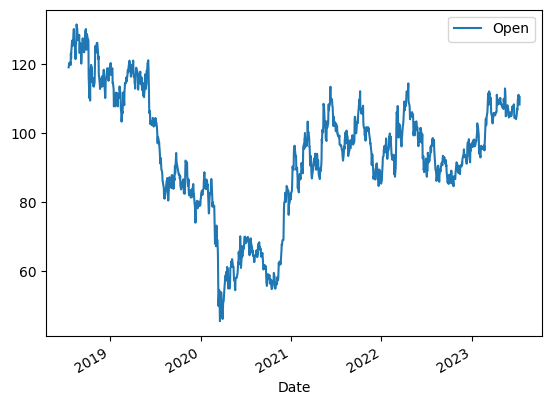

In [9]:
opn.plot()

In [10]:
import matplotlib.pyplot as plt

In [11]:
ds = opn.values

In [12]:
ds

array([[118.93333435],
       [119.33333588],
       [120.18333435],
       ...,
       [109.        ],
       [110.59999847],
       [108.19999695]])

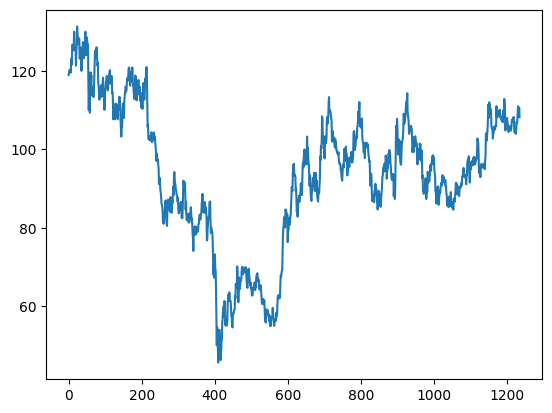

In [13]:
plt.plot(ds)

In [14]:
import numpy as np

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [17]:
len(ds_scaled), len(ds)

(1234, 1234)

In [18]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [19]:
train_size,test_size

(863, 371)

In [20]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [21]:
len(ds_train),len(ds_test)

(863, 371)

In [22]:
#creating dataset in time series for LSTM model
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [23]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [24]:
X_train.shape,y_train.shape

((762, 100), (762,))

In [25]:
X_test.shape, y_test.shape

((270, 100), (270,))

In [26]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [56]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU

In [58]:
# GRU

model = Sequential()
model.add(GRU(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(GRU(units=50,return_sequences=True))
model.add(GRU(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 50)           7950      
                                                                 
 gru_1 (GRU)                 (None, 100, 50)           15300     
                                                                 
 gru_2 (GRU)                 (None, 50)                15300     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 38,601
Trainable params: 38,601
Non-trainable params: 0
_________________________________________________________________


In [60]:
from keras.callbacks import ModelCheckpoint

In [61]:
import os

model_path = 'model/'
absolute_model_path = os.path.abspath(model_path)

print("Model path:", absolute_model_path)

Model path: /content/model


In [62]:
#Training model with adam optimizer and mean squared error loss function
cp = ModelCheckpoint('model/',save_best_only=True)
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,callbacks=[cp])

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.0030

12/12 [==============================] - 14s 873ms/step - loss: 0.0030 - val_loss: 3.8244e-04
Epoch 2/100
12/12 [==============================] - 2s 171ms/step - loss: 0.0012 - val_loss: 5.4376e-04
Epoch 3/100
12/12 [==============================] - 1s 120ms/step - loss: 7.7034e-04 - val_loss: 5.6672e-04
Epoch 4/100
12/12 [==============================] - 1s 120ms/step - loss: 6.6284e-04 - val_loss: 3.9568e-04
Epoch 5/100
12/12 [==============================] - 1s 119ms/step - loss: 5.9314e-04 - val_loss: 3.8719e-04
Epoch 6/100
12/12 [==============================] - 1s 120ms/step - loss: 5.6276e-04 - val_loss: 3.8636e-04
Epoch 7/100
12/12 [==============================] - 1s 119ms/step - loss: 5.6759e-04 - val_loss: 4.0395e-04
Epoch 8/100
12/12 [==============================] - 1s 118ms/step - loss: 5.8989e-04 - val_loss: 4.1420e-04
Epoch 9/100
12/12 [==============================] - ETA: 0s - loss: 6.0429e-04

12/12 [==============================] - 10s 856ms/step - loss: 6.0429e-04 - val_loss: 3.7662e-04
Epoch 10/100
12/12 [==============================] - 1s 121ms/step - loss: 6.0930e-04 - val_loss: 3.8285e-04
Epoch 11/100
12/12 [==============================] - 1s 120ms/step - loss: 6.3055e-04 - val_loss: 4.6951e-04
Epoch 12/100
12/12 [==============================] - ETA: 0s - loss: 5.8194e-04

12/12 [==============================] - 9s 809ms/step - loss: 5.8194e-04 - val_loss: 3.7179e-04
Epoch 13/100
12/12 [==============================] - 1s 116ms/step - loss: 5.5399e-04 - val_loss: 5.2896e-04
Epoch 14/100
12/12 [==============================] - 1s 119ms/step - loss: 5.5497e-04 - val_loss: 3.9308e-04
Epoch 15/100
12/12 [==============================] - 3s 264ms/step - loss: 5.6273e-04 - val_loss: 3.9055e-04
Epoch 16/100
12/12 [==============================] - 1s 116ms/step - loss: 5.9414e-04 - val_loss: 3.7620e-04
Epoch 17/100
12/12 [==============================] - 1s 115ms/step - loss: 5.7481e-04 - val_loss: 4.1194e-04
Epoch 18/100
12/12 [==============================] - 1s 115ms/step - loss: 5.7214e-04 - val_loss: 3.9920e-04
Epoch 19/100
12/12 [==============================] - 1s 115ms/step - loss: 5.5813e-04 - val_loss: 3.7537e-04
Epoch 20/100
12/12 [==============================] - 1s 115ms/step - loss: 5.4915e-04 - val_loss: 3.9055e-04
Epoch 21/100
12/12 [===

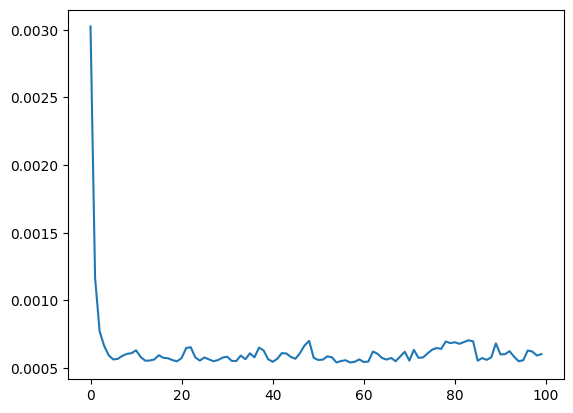

In [63]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [67]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 20ms/step


In [69]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

In [70]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse


import math
from math import sqrt


mae_ = mae(y_test,test_predict)
mse_ = mse(y_test, test_predict)
rmse = sqrt(mse_)
print("Mean Absolute Error : ", mae_)
print("Mean Squared Error : ",mse_)
print('RMSE : ',rmse)

Mean Absolute Error :  97.28489560552683
Mean Squared Error :  9524.61084842366
RMSE :  97.59411277543158


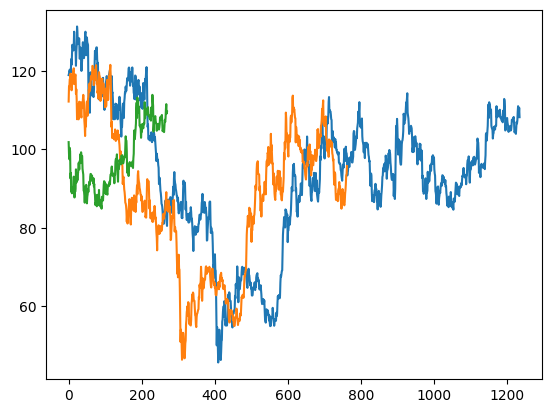

In [71]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [72]:
type(train_predict)

numpy.ndarray

In [73]:
test = np.vstack((train_predict,test_predict))

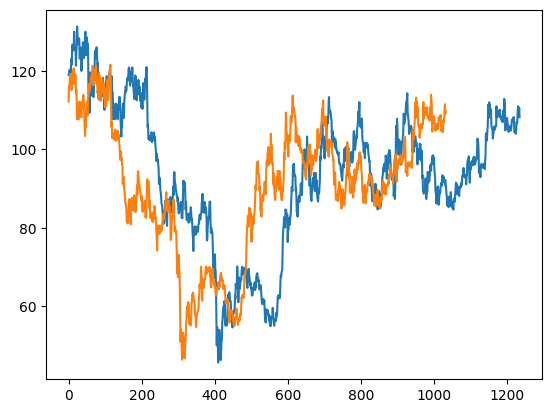

In [74]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [75]:
len(ds_test)

371

In [76]:
#Getting the last 100 days records
fut_inp = ds_test[270:]

In [77]:
fut_inp = fut_inp.reshape(1,-1)

In [78]:
tmp_inp = list(fut_inp)

In [79]:
fut_inp.shape

(1, 101)

In [80]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [81]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[[0.7309150695800781], [0.7386527061462402], [0.7434918880462646], [0.7494259476661682], [0.7552315592765808], [0.761048436164856], [0.7668521404266357], [0.7726457118988037], [0.7784320712089539], [0.7842105627059937], [0.7899795770645142], [0.7957369685173035], [0.8014797568321228], [0.8072055578231812], [0.812911331653595], [0.8185942769050598], [0.824251651763916], [0.8298807144165039], [0.8354788422584534], [0.84104323387146], [0.8465712070465088], [0.8520601391792297], [0.8575072884559631], [0.8629102110862732], [0.8682664632797241], [0.8735734224319458], [0.8788285851478577], [0.8840298652648926], [0.8891750574111938], [0.8942618370056152]]


In [82]:
len(ds_scaled)

1234

In [83]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,103)
plot_pred=np.arange(101,131)

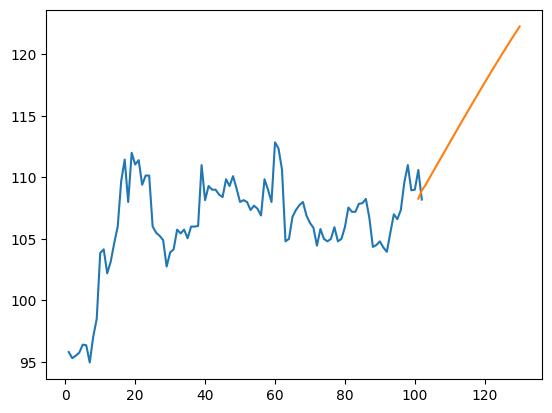

In [84]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1132:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [85]:
ds_new = ds_scaled.tolist()

In [86]:
len(ds_new)

1234

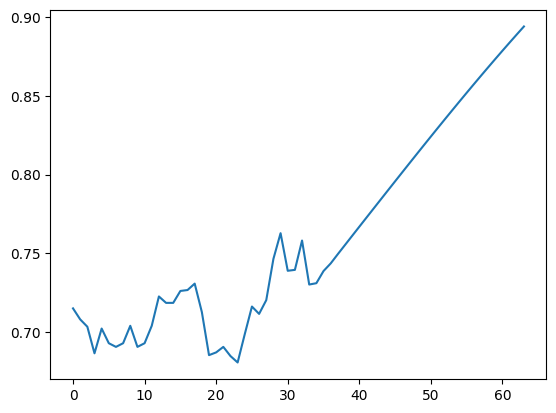

In [87]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [88]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

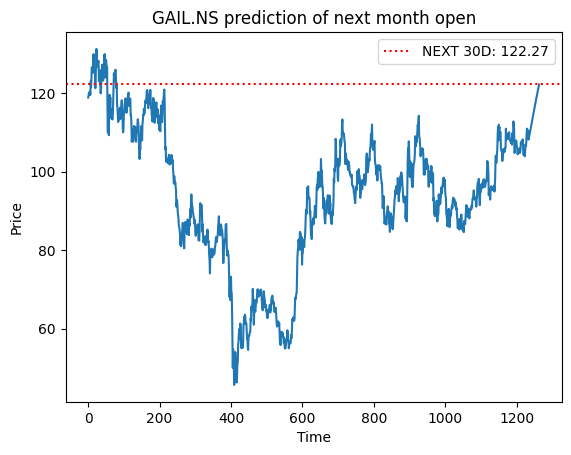

In [89]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

